In [3]:
import pandas as pd
import seaborn as sns

%matplotlib inline

In [4]:
!ls -l input

total 1912
-rw-r--r--@ 1 alexandrelacheze  staff  323856 Aug 23 15:00 test.csv
-rw-r--r--@ 1 alexandrelacheze  staff  648353 Aug 23 15:00 train.csv


In [5]:
pd.read_csv?

In [6]:
train = pd.read_csv("./input/train.csv", parse_dates=['datetime'], dtype={'datetime':pd.datetime})
test = pd.read_csv("./input/test.csv", parse_dates=['datetime'], dtype={'datetime':pd.datetime})

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [8]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
train['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [10]:
train['count'].isnull().sum()

0

In [11]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


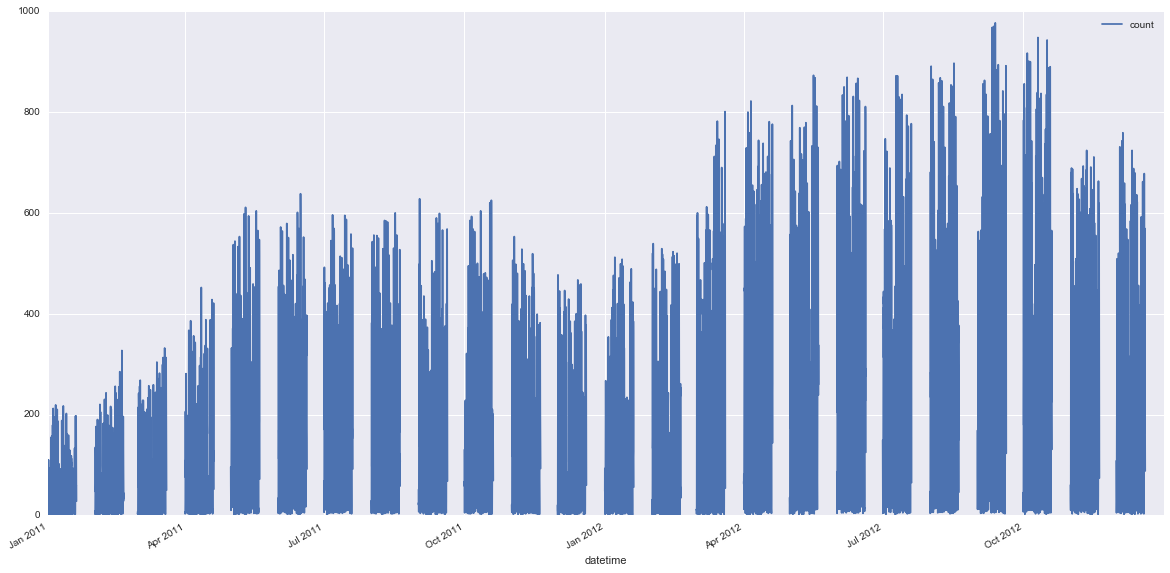

In [12]:
pd.concat([train, test]).plot( 'datetime', 'count', figsize=(20,10))

In [13]:
from sklearn import cross_validation

In [33]:
train['humidity'].isnull().sum()

0

In [51]:
# feature and target preparation
def prepare_feature(train):
    train['hour'] = train.datetime.apply(lambda dt: dt.hour)
    train['month'] = train.datetime.apply(lambda dt: dt.month)
    train['dayofweek'] = train.datetime.apply(lambda dt: dt.dayofweek)
    train['year'] = train.datetime.apply(lambda dt: dt.year)
    return train[[
            #'temp', 
            #'windspeed',
            'holiday',
            'season',
            'workingday',
            'weather',
            'atemp',
            'hour',
            'month',
            'humidity',
            'dayofweek',
            'year'
        ]]

X = prepare_feature(train)
y = train['count']

In [15]:
# gotta implement the  Root Mean Squared Logarithmic Error (RMSLE)
from IPython.display import display, Math, Latex
display(Math(r'RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }'))

<IPython.core.display.Math object>

In [16]:
Y_true_cul, Y_pred_cul = None, None
import numpy as np
from sklearn.metrics import make_scorer
def root_mean_squared_logarithmic_error(y_true, y_pred):
    y_pred = np.maximum(np.zeros_like(y_pred), y_pred)
    output_errors = np.sqrt(np.average((np.log(y_pred+1) - np.log(y_true+1)) ** 2, axis=0))
    print output_errors
    return output_errors

rmsle_scorer = make_scorer(root_mean_squared_logarithmic_error, greater_is_better=False)

In [29]:
# test RMSLE
p = np.array([20, 30])
a = np.array([22, 28])
root_mean_squared_logarithmic_error(a, p)

0.0797609047793


0.079760904779328012

In [80]:
# model
from sklearn import linear_model, ensemble, svm

#clf = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0])
#clf = svm.LinearSVR()
clf = ensemble.RandomForestRegressor()

In [81]:
scores = cross_validation.cross_val_score(clf, X, y, cv=10, scoring=rmsle_scorer)
print("Loss: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

0.682101080745
0.5330375554
0.284587474057
0.383324806883
0.431567537765
0.561149413805
0.42669839091
0.279841787052
0.313444548036
0.353908752449
Loss: 0.42 (+/- 0.25)


In [20]:
from sklearn.grid_search import GridSearchCV

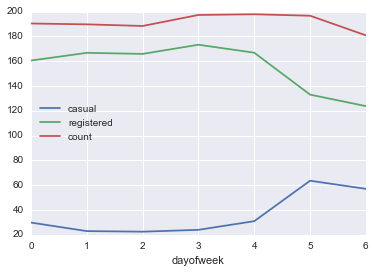

In [21]:
train.groupby('dayofweek')[['casual', 'registered', 'count']].mean().plot()

In [70]:
clf.fit_transform(prepare_feature(train), train['count'])
res = clf.predict(prepare_feature(test))

/usr/local/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


In [76]:
submission = test.copy()[['datetime']]
submission['count'] = pd.Series(res).round().astype(int)

In [78]:
submission.to_csv('./output/submission.csv', index=False)

In [68]:
# does it change anything to work with the log(1+x) directly and use MSE?

#  => nothing!!!

In [47]:
train['count_log'] = np.log(train['count'] + 1)

In [67]:
clf = ensemble.RandomForestRegressor()
scores = cross_validation.cross_val_score(clf, X, train['count_log'], cv=5, scoring='mean_squared_error')
print("Loss: %0.2f (+/- %0.2f)" % (np.sqrt(-scores.mean()), scores.std() * 2))

Loss: 0.47 (+/- 0.29)


In [83]:
y_r = train['registered']
clf_r = ensemble.RandomForestRegressor(
    n_estimators = 1000, 
    min_samples_split = 12, 
    n_jobs = -1
)
clf_r.fit_transform(prepare_feature(train), y_r)
test_y_r = clf_r.predict(prepare_feature(test))

clf_c = ensemble.RandomForestRegressor(
    n_estimators = 1000, 
    min_samples_split = 12, 
    n_jobs = -1
)
y_c = train['casual']
clf_c.fit_transform(prepare_feature(train), y_c)
test_y_c = clf_c.predict(prepare_feature(test))

test_y_count = test_y_c+test_y_r

submission = test.copy()[['datetime']]
submission['count'] = pd.Series(test_y_count).round().astype(int)

submission.to_csv('./output/submission.csv', index=False)

/usr/local/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
